### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import warnings
%matplotlib inline
warnings.filterwarnings("ignore", category=UserWarning)
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

import time
from sklearn import metrics

### Getting Data
##### Getting Data From Csv's

In [2]:
cards_data = pd.read_csv('datasets/cards_data.csv')
users_data = pd.read_csv('datasets/users_data.csv')
users_data.head()

,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,$59696,$127613,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,$37891,$77254,$191349,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,$22681,$33483,$196,698,5
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,$163145,$249925,$202328,722,4
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,$53797,$109687,$183855,675,1


##### Getting Data From Json's

In [3]:
with open('datasets/mcc_codes.json','r') as mcc_codes:
    data = json.load(mcc_codes)
with open('datasets/train_fraud_labels.json','r') as fraud_label:
    target = json.load(fraud_label)

In [4]:
mcc_codes = pd.DataFrame(list(data.items()), columns=['mcc', 'Description'])
fraud_label_target = pd.DataFrame(list(target.get('target').items()), columns=['transaction_id', 'fraud'])

##### Getting Data from Database

In [5]:
from db_connection import connect_to_db
connection = connect_to_db()
query = "SELECT * FROM transaction"
transaction_data = pd.read_sql(query, connection)

In [6]:
fraud_label_target.transaction_id  = fraud_label_target.transaction_id.astype(int)
transaction_data.date = pd.to_datetime(transaction_data.date)

### Merging and preprocessing the required DataFrames

In [7]:
transaction_data.head()

,id,date,client_id,card_id,amount,transaction_mode,merchant_id,merchant_city,merchant_state,zip,mcc,error
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523,5499,None
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,5311,None
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084,4829,None
3,7475331,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307,4829,None
4,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,5813,None


In [8]:
online_mask = transaction_data['merchant_city'] == 'ONLINE'
transaction_data.loc[online_mask, 'merchant_state'] = 'ONLINE'
transaction_data.loc[online_mask, 'zip'] = 'ONLINE'
transaction_data['zip'] = transaction_data['zip'].fillna('FOREIGN') 

In [9]:
import pgeocode

nomi = pgeocode.Nominatim('us')

valid_zip_mask = ~transaction_data['zip'].isin(['ONLINE', 'FOREIGN'])
numeric_zip_mask = transaction_data['zip'].apply(lambda x: str(x).isdigit() if pd.notna(x) else False)
valid_zips = transaction_data.loc[valid_zip_mask & numeric_zip_mask, 'zip'].astype(str)

unique_zips = valid_zips.unique()

lat_lon_lookup = pd.DataFrame(unique_zips, columns=['zip'])
lat_lon_lookup[['t_latitude', 't_longitude']] = lat_lon_lookup['zip'].apply(
    lambda z: pd.Series(nomi.query_postal_code(z)[['latitude', 'longitude']])
)

transaction_data = transaction_data.merge(lat_lon_lookup, on='zip', how='left')

In [10]:
transaction_data['transaction_type'] = transaction_data.apply(
    lambda row: 'ONLINE' if row['zip'] == 'ONLINE' 
    else ('FOREIGN' if row['zip'] == 'FOREIGN' else 'OFFLINE'),
    axis=1
)

In [11]:
transaction_data['repeat_transaction'] = transaction_data.duplicated(
    subset=['client_id', 'merchant_id','transaction_type'], keep='first'
)
transaction_data['repeat_transaction'] = transaction_data['repeat_transaction'].astype(int)

In [12]:
transaction_fraud = transaction_data.merge(fraud_label_target,how='left',left_on='id', right_on='transaction_id')
transaction_fraud.drop(['id','transaction_id'],inplace=True,axis =1)

In [13]:
main_df = transaction_fraud.merge(users_data[['id','latitude', 'longitude']],how='left',left_on='client_id', right_on='id')
main_df.drop('id',inplace=True,axis =1)

In [14]:
main_df.head()

,date,client_id,card_id,amount,transaction_mode,merchant_id,merchant_city,merchant_state,zip,mcc,error,t_latitude,t_longitude,transaction_type,repeat_transaction,fraud,latitude,longitude
0,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523,5499,None,47.2707,-101.8075,OFFLINE,0,No,46.80,-100.76
1,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,5311,None,41.5509,-90.4942,OFFLINE,0,No,40.80,-91.12
2,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084,4829,None,33.2131,-117.2243,OFFLINE,0,No,33.18,-117.29
3,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307,4829,None,41.4236,-87.3556,OFFLINE,0,NaN,41.42,-87.35
4,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,5813,None,38.8582,-76.6145,OFFLINE,0,No,38.86,-76.60


In [15]:
mask = (
    (main_df['transaction_type'] == 'OFFLINE') &
    main_df[['latitude','longitude','t_latitude','t_longitude']].notna().all(axis=1)
)

# Vectorized haversine
lat1 = np.radians(main_df.loc[mask, 'latitude'])
lon1 = np.radians(main_df.loc[mask, 'longitude'])
lat2 = np.radians(main_df.loc[mask, 't_latitude'])
lon2 = np.radians(main_df.loc[mask, 't_longitude'])

dlat = lat2 - lat1
dlon = lon2 - lon1

a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

main_df.loc[mask, 'distance_km'] = 6371.0 * c  # Earth radius in km

# Optional: distance in miles
main_df['distance_miles'] = main_df['distance_km'] * 0.621371

In [16]:
del lat_lon_lookup
del valid_zips
del unique_zips
del users_data
del cards_data
del mcc_codes
del transaction_data
del transaction_fraud
del mask


import gc
gc.collect()

0

In [17]:
main_df['updated_amt'] = np.where(main_df.amount<0,main_df.amount*-1,main_df.amount)
main_df['fraud'] = main_df['fraud'].map({'Yes': 1, 'No': 0})
main_df.fraud.isna().sum()

np.int64(4390952)

In [18]:
# Creating a new dataframe by grouping in order to calculate risk score for each client
client_card_df = main_df[['client_id','card_id','fraud','updated_amt']].groupby(['client_id','card_id','fraud']).agg(
        mean_amount=('updated_amt', 'mean'),
        max_amount=('updated_amt', 'max'),
        min_amount=('updated_amt', 'min'),
        total_amount=('updated_amt', 'sum'),
        count=('updated_amt', 'count')
    ).reset_index()
client_card_df.head()

,client_id,card_id,fraud,mean_amount,max_amount,min_amount,total_amount,count
0,0,1271,0.0,45.904068,577.46,0.65,212122.70,4621
1,0,1271,1.0,30.260000,45.48,15.04,60.52,2
2,0,4639,0.0,80.186643,1128.47,0.78,322270.12,4019
3,0,4639,1.0,70.697500,129.40,5.13,282.79,4
4,1,3682,0.0,39.487578,542.66,0.54,45331.74,1148


In [19]:
# Aggregate fraud and total data    
grouped = client_card_df.groupby(['client_id', 'card_id', 'fraud']).agg(
    fraud_count=('count', 'sum'),
    fraud_amount=('total_amount', 'sum')
).reset_index()

# Pivot to get fraud and non-fraud side by side
pivoted = grouped.pivot(index=['client_id', 'card_id'], columns='fraud', values=['fraud_count', 'fraud_amount'])
pivoted.columns = ['count_nonfraud', 'count_fraud', 'amount_nonfraud', 'amount_fraud']
pivoted = pivoted.fillna(0).reset_index()

# Calculate percentages
pivoted['fraud_count_pct'] = round(100 * pivoted['count_fraud'] / (pivoted['count_fraud'] + pivoted['count_nonfraud']),2)
pivoted['fraud_amount_pct'] = round(100 * pivoted['amount_fraud'] / (pivoted['amount_fraud'] + pivoted['amount_nonfraud']),2)


In [20]:
pivoted.sort_values('fraud_count_pct').tail(20)

,client_id,card_id,count_nonfraud,count_fraud,amount_nonfraud,amount_fraud,fraud_count_pct,fraud_amount_pct
1886,944,372,215.0,7.0,16559.83,302.10,3.15,1.79
1016,496,5806,744.0,25.0,55509.13,1953.57,3.25,3.40
3540,1746,3754,378.0,13.0,9137.06,5125.89,3.32,35.94
954,467,4481,140.0,5.0,4808.77,399.07,3.45,7.66
1553,764,1381,301.0,11.0,15931.26,518.41,3.53,3.15
1204,604,4280,281.0,11.0,5293.04,4386.14,3.77,45.32
1952,980,181,234.0,10.0,10426.70,982.01,4.10,8.61
2335,1176,2629,210.0,9.0,15160.67,1957.95,4.11,11.44
1524,754,2219,199.0,9.0,6271.47,680.40,4.33,9.79
2622,1302,3972,62.0,3.0,528.90,82.17,4.62,13.45


In [21]:
pivoted.sort_values('fraud_amount_pct').tail(20)

,client_id,card_id,count_nonfraud,count_fraud,amount_nonfraud,amount_fraud,fraud_count_pct,fraud_amount_pct
3428,1694,5032,1252.0,19.0,22950.16,2953.21,1.49,11.40
2335,1176,2629,210.0,9.0,15160.67,1957.95,4.11,11.44
1687,840,4992,264.0,5.0,8744.63,1199.46,1.86,12.06
3716,1833,2345,341.0,6.0,18923.75,2815.74,1.73,12.95
3939,1942,246,1607.0,5.0,8350.50,1254.38,0.31,13.06
2622,1302,3972,62.0,3.0,528.90,82.17,4.62,13.45
2024,1016,5883,501.0,8.0,9896.90,1992.37,1.57,16.76
3918,1928,2442,894.0,19.0,11905.08,2828.68,2.08,19.20
2981,1492,2171,560.0,9.0,4755.17,1461.11,1.58,23.50
2188,1102,3952,1413.0,37.0,20193.51,7097.85,2.55,26.01


In [22]:
# Function to calculate risk score
def compute_risk_score(row):
    fraud_amt_threshold = pivoted[pivoted['fraud_count_pct']>0]['amount_fraud'].quantile(0.75)
    fraud_cnt_pct_threshold = pivoted[pivoted['fraud_count_pct']>0]['fraud_count_pct'].quantile(0.75)
    fraud_amt_pct_threshold = pivoted[pivoted['fraud_count_pct']>0]['fraud_amount_pct'].quantile(0.75)
    score = 0
    if row['fraud_count_pct'] > fraud_cnt_pct_threshold:
        score += 1
    if row['fraud_amount_pct'] > fraud_amt_pct_threshold:
        score += 1
    if row['amount_fraud'] > fraud_amt_threshold:
        score += 1
    return score

In [23]:
pivoted['risk_score'] = pivoted.apply(compute_risk_score, axis=1)

In [24]:
main_df = main_df.merge(pivoted.rename(columns={'card_id': 'cc_id'})[['risk_score', 'cc_id']],how='left',left_on='card_id',right_on='cc_id')
main_df.drop('cc_id',inplace=True,axis =1)
main_df.head()

,date,client_id,card_id,amount,transaction_mode,merchant_id,merchant_city,merchant_state,zip,mcc,error,t_latitude,t_longitude,transaction_type,repeat_transaction,fraud,latitude,longitude,distance_km,distance_miles,updated_amt,risk_score
0,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523,5499,None,47.2707,-101.8075,OFFLINE,0,0.0,46.80,-100.76,95.084379,59.082675,77.00,3.0
1,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,5311,None,41.5509,-90.4942,OFFLINE,0,0.0,40.80,-91.12,98.563877,61.244735,14.57,0.0
2,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084,4829,None,33.2131,-117.2243,OFFLINE,0,0.0,33.18,-117.29,7.135686,4.433909,80.00,0.0
3,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307,4829,None,41.4236,-87.3556,OFFLINE,0,NaN,41.42,-87.35,0.615033,0.382164,200.00,0.0
4,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,5813,None,38.8582,-76.6145,OFFLINE,0,0.0,38.86,-76.60,1.271358,0.789985,46.41,2.0


In [25]:
del pivoted
del grouped
del client_card_df
gc.collect()

0

In [26]:
columns = ['amount','transaction_type', 'repeat_transaction', 'transaction_mode','distance_km','risk_score','fraud']
main_df = main_df[columns]
main_df.head()

,amount,transaction_type,repeat_transaction,transaction_mode,distance_km,risk_score,fraud
0,-77.00,OFFLINE,0,Swipe Transaction,95.084379,3.0,0.0
1,14.57,OFFLINE,0,Swipe Transaction,98.563877,0.0,0.0
2,80.00,OFFLINE,0,Swipe Transaction,7.135686,0.0,0.0
3,200.00,OFFLINE,0,Swipe Transaction,0.615033,0.0,NaN
4,46.41,OFFLINE,0,Swipe Transaction,1.271358,2.0,0.0


In [27]:
without_distance_df = main_df[main_df.distance_km.isna()].drop('distance_km', axis = 1).copy()
with_distance_df = main_df[~main_df.distance_km.isna()].copy()

In [28]:
without_distance_df

,amount,transaction_type,repeat_transaction,transaction_mode,risk_score,fraud
7,26.46,ONLINE,0,Online Transaction,0.0,0.0
8,261.58,ONLINE,0,Online Transaction,0.0,NaN
18,26.04,ONLINE,0,Online Transaction,0.0,0.0
24,10.17,ONLINE,0,Online Transaction,1.0,0.0
26,16.86,ONLINE,0,Online Transaction,0.0,NaN
...,...,...,...,...,...,...
13305891,37.20,OFFLINE,1,Chip Transaction,0.0,NaN
13305894,61.67,OFFLINE,1,Chip Transaction,0.0,NaN
13305897,694.30,ONLINE,1,Online Transaction,0.0,0.0
13305902,55.10,OFFLINE,1,Chip Transaction,0.0,0.0


In [29]:
del main_df
gc.collect()

0

In [30]:
# Separating the data who have 'null' in fraud
final_test_df_not_offline = without_distance_df[without_distance_df.fraud.isna()].drop('fraud',axis =1)
print(final_test_df_not_offline.shape)
final_test_df_not_offline.head()

(812095, 5)


,amount,transaction_type,repeat_transaction,transaction_mode,risk_score
8,261.58,ONLINE,0,Online Transaction,0.0
26,16.86,ONLINE,0,Online Transaction,0.0
34,2.95,OFFLINE,0,Swipe Transaction,0.0
42,3.96,OFFLINE,0,Swipe Transaction,0.0
43,12.67,ONLINE,1,Online Transaction,0.0


In [31]:
final_test_df_offline = with_distance_df[with_distance_df.fraud.isna()].drop('fraud',axis =1)
print(final_test_df_offline.shape)
final_test_df_offline.head()

(3578857, 6)


,amount,transaction_type,repeat_transaction,transaction_mode,distance_km,risk_score
3,200.00,OFFLINE,0,Swipe Transaction,0.615033,0.0
6,77.00,OFFLINE,1,Swipe Transaction,95.084379,3.0
9,10.74,OFFLINE,0,Swipe Transaction,2.339468,0.0
15,1.09,OFFLINE,0,Swipe Transaction,46.724910,0.0
23,57.54,OFFLINE,0,Swipe Transaction,1.005177,0.0


In [32]:
with_distance_df.dropna(subset = ['fraud'], inplace=True)
without_distance_df.dropna(subset = ['fraud'], inplace=True)

##### Image for Correlation plot - https://github.com/yashjadwani/Financial-Fraud-Analysis/blob/main/Corr%20plot.png
##### Code for detailed Analysis and EDA - https://github.com/yashjadwani/Financial-Fraud-Analysis/blob/main/fraud_detection.ipynb

## Model Building
##### Anamoly Detection AutoEncoder

In [48]:
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

class AutoencoderGMMDetector(BaseEstimator, TransformerMixin):
    def __init__(self, code_dim=2, epochs=25, batch_size=256, n_components=2,
                 learning_rate=0.001, anomaly_percentile=5):
        self.code_dim = code_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.n_components = n_components
        self.learning_rate = learning_rate
        self.anomaly_percentile = anomaly_percentile
        
        self.autoencoder = None
        self.gmm = None
        self.threshold = None
        self._history = None  
    
    def build_model(self, input_shape):
        inp = Input(shape=(input_shape,))
        x = Dense(64, activation='relu')(inp) 
        x = Dense(32, activation='relu')(x)
        x = Dense(16, activation='relu')(x)
        code = Dense(self.code_dim, activation='relu')(x)
        x = Dense(16, activation='relu')(code)
        x = Dense(32, activation='relu')(x)
        x = Dense(64, activation='relu')(x)
        out = Dense(input_shape, activation='linear')(x)
        return Model(inp, out)
    
    def fit(self, X, y=None):
        input_shape = X.shape[1]
        self.autoencoder = self.build_model(input_shape)
        self.autoencoder.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mse')

        earlystop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

        self._history = self.autoencoder.fit(
            X, X,
            epochs=self.epochs,
            batch_size=self.batch_size,
            validation_split=0.25,
            callbacks=[earlystop],
            shuffle=True,
            verbose=1
        )

        # Compute reconstruction errors
        recon = self.autoencoder.predict(X, batch_size=self.batch_size, verbose=0)
        errors = np.mean(np.abs(recon - X), axis=1).reshape(-1,1)

        # Fit GMM
        self.gmm = GaussianMixture(n_components=self.n_components, covariance_type='full', random_state=42)
        self.gmm.fit(errors)

        # Threshold = bottom percentile of log-likelihood
        log_likelihood = self.gmm.score_samples(errors)
        self.threshold = np.percentile(log_likelihood, self.anomaly_percentile)
        print(f"Anomaly log-likelihood threshold set at {self.threshold:.6f} "
              f"(bottom {self.anomaly_percentile} percentile)")

        return self

    @property
    def history(self):
        return self._history

    def score_samples(self, X):
        recon = self.autoencoder.predict(X, batch_size=self.batch_size, verbose=0)
        errors = np.mean(np.abs(recon - X), axis=1).reshape(-1,1)
        return self.gmm.score_samples(errors)

    def predict(self, X):
        scores = self.score_samples(X)
        return (scores < self.threshold).astype(int)  # 1 = anomaly/fraud

    def plot_training_loss(self):
        plt.figure(figsize=(10,6))
        plt.plot(self._history.history['loss'], label='Training Loss')
        plt.plot(self._history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.title('Autoencoder Training Curve(Loss Function)')
        plt.legend()
        plt.grid(True)
        plt.show()

* The purpose of this fully-connected feedforward autoencoder is to identify anomalies in transaction data. An encoder (64 → 32 → 16 → code) compresses the input features into a low-dimensional latent space (code_dim), which is then reconstructed using a symmetric decoder (16 → 32 → 64 → output). Anomaly likelihoods are calculated by modelling the reconstruction error using a Gaussian Mixture Model (GMM). Anomalies (possible fraud) are transactions whose log-likelihood is less than the designated percentile (anomaly_percentile). Early halting avoids overfitting, and the network is trained using Mean Squared Error (MSE) loss with Adam optimiser.

In [49]:
### Evaluation Metrics

def evaluate(y_test,y_preds):
    print(f"Accuracy: {accuracy_score(y_test, y_preds):.4f}")
    print(f"Precision: {precision_score(y_test, y_preds, zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_test, y_preds, zero_division=0):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_preds, zero_division=0):.4f}")
    print(f"Matthews Corrcoef: {matthews_corrcoef(y_test, y_preds):.4f}")
    print(f"Correctly Predicted Samples: {(y_preds == y_test).sum()} / {len(y_test)}")
    print('=================================================')
    confusion_matrix = metrics.confusion_matrix(y_test, y_preds)
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix,
        display_labels=['Non-Fraud', 'Fraud']
    )
    cm_display.plot(cmap='Blues')
    plt.show()

In [50]:
#### Evaluation Metrics for XGB 

from sklearn.metrics import precision_recall_curve

def eval_classification(pipeline,x_test, y_test):
    y_probs = pipeline.predict_proba(x_test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

    plt.plot(thresholds, precision[:-1], label='Precision')
    plt.plot(thresholds, recall[:-1], label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_idx = f1_scores.argmax()
    best_threshold = thresholds[best_idx]
    print("Best threshold:", best_threshold)

    y_pred = (y_probs >= best_threshold).astype(int)

    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred, zero_division=0):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred, zero_division=0):.4f}")
    print(f"Matthews Corrcoef: {matthews_corrcoef(y_test, y_pred):.4f}")
    print(f"Correctly Predicted Samples: {(y_pred == y_test).sum()} / {len(y_test)}")
    print('=================================================')
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix,
        display_labels=['Non-Fraud', 'Fraud']
    )
    cm_display.plot(cmap='Blues')
    plt.show()

#### Classifiers

In [51]:
from xgboost import XGBClassifier

XGB_Classifier =  XGBClassifier(
        random_state=42,
        eval_metric='logloss'
    )



#### No Distance Avaliable

In [52]:

cat_cols = ['transaction_type', 'repeat_transaction', 'transaction_mode','risk_score']
num_cols = ['distance_km']

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
        #('num', MinMaxScaler(), num_cols)
    ]
)

In [53]:
X = without_distance_df.drop(columns=['fraud'])
y = without_distance_df['fraud']

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

X_train_genuine = X_train_full[y_train_full == 0]

##### Auto Encoder training

Epoch 1/25
15354/15354 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 0.0056 - val_loss: 9.5960e-04
Epoch 2/25
15354/15354 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - loss: 6.4878e-04 - val_loss: 4.2149e-04
Epoch 3/25
15354/15354 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - loss: 3.7669e-04 - val_loss: 2.8156e-04
Epoch 4/25
15354/15354 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - loss: 2.7018e-04 - val_loss: 2.3616e-04
Epoch 5/25
15354/15354 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - loss: 1.4812e-04 - val_loss: 9.9306e-05
Epoch 6/25
15354/15354 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - loss: 8.7906e-05 - val_loss: 5.3745e-05
Epoch 7/25
15354/15354 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - loss: 7.7705e-05 - val_loss: 6.5775e-05
Epoch 8/25
15354/15354 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - loss: 7.0246e-05 - val_loss: 5.5613e-05
Epoch 9/25
15354/15354 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - loss: 6.9828e-05 - val_loss: 4.1689e-05
Epoch 10/25
15354/15354 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - loss: 5.5227e-05 - val_loss: 4.1041e-05
Epoch 11/25
1

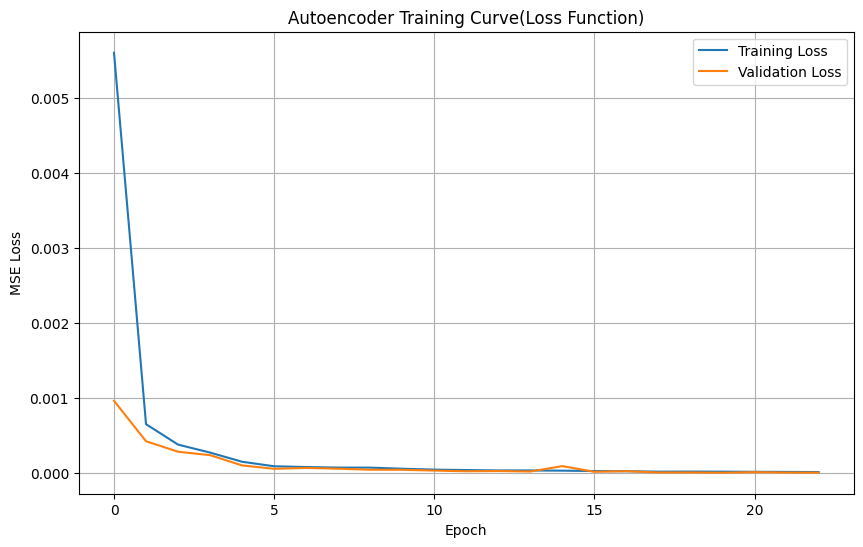

c:\Users\yashj\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\yashj\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Accuracy: 0.9087
Precision: 0.0570
Recall: 0.7313
F1 Score: 0.1057
Matthews Corrcoef: 0.1874
Correctly Predicted Samples: 299848 / 329977


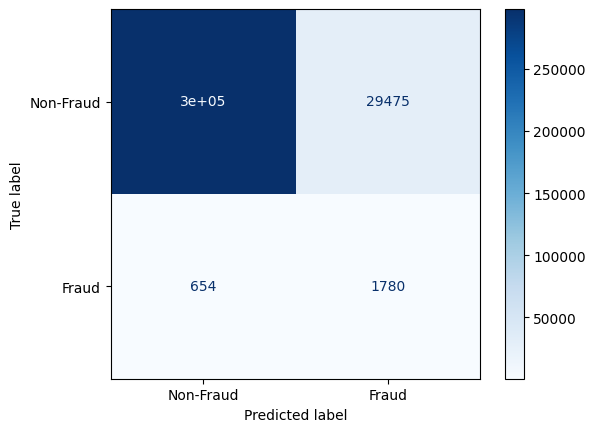

In [54]:
autoencoder_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('autoencoder', AutoencoderGMMDetector(code_dim=2, epochs=25, batch_size=64, n_components=2,learning_rate=0.0005,anomaly_percentile=10))
])

autoencoder_pipeline.fit(X_train_genuine)

autoencoder_pipeline.named_steps['autoencoder'].plot_training_loss()

X_test_full['anomaly_flag'] = autoencoder_pipeline.predict(X_test_full)
X_test_full['anomaly_score'] = autoencoder_pipeline.score_samples(X_test_full)

evaluate(y_test_full,X_test_full['anomaly_flag'])


##### Classification training

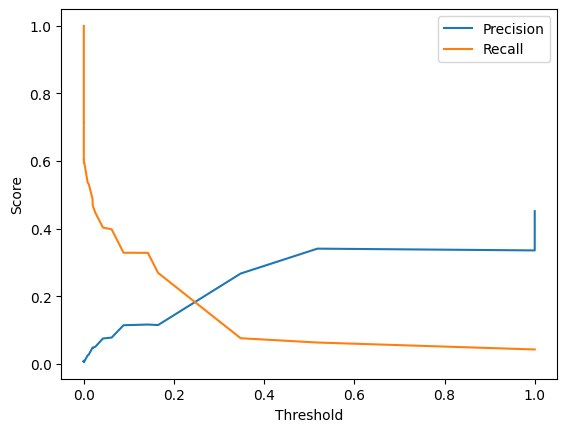

Best threshold: 0.14205983
Accuracy: 0.9766
Precision: 0.1161
Recall: 0.3283
F1 Score: 0.1716
Matthews Corrcoef: 0.1855
Correctly Predicted Samples: 322260 / 329977


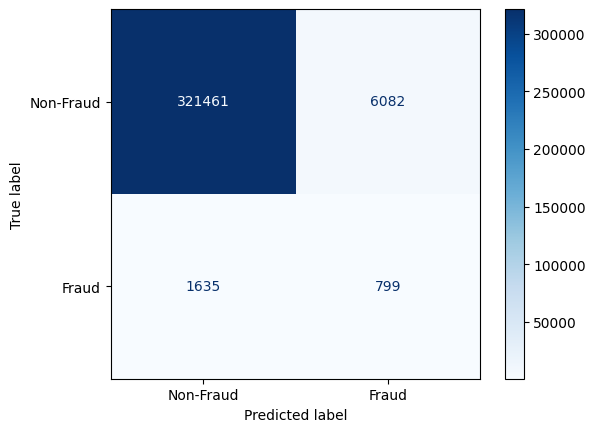

In [55]:
xgb_pipeline = Pipeline(steps=[
        ('preprocess', preprocess),
        ('model', XGB_Classifier)
])

xgb_pipeline.fit(X_train_full,y_train_full)

eval_classification(xgb_pipeline,X_test_full,y_test_full)

In [56]:
import joblib
import json
import os
save_dir = "Models/AutoEncoders"


joblib.dump(preprocess, os.path.join(save_dir, "autoencoder_without_distance_preprocess.pkl"))

detector = autoencoder_pipeline.named_steps["autoencoder"]
detector.autoencoder.save(os.path.join(save_dir, "autoencoder_without_distance_autoencoder.keras"))

joblib.dump(detector.gmm,  os.path.join(save_dir, "autoencoder_without_distance_gmm.pkl"))

with open(os.path.join(save_dir, "autoencoder_without_distance_threshold.json"), "w") as f:
        json.dump({"threshold": float(detector.threshold)}, f)

save_dir = "Models/Classifier"
joblib.dump(xgb_pipeline, os.path.join(save_dir, "xgb_pipeline_without_distance.pkl"))

['Models/Classifier\\xgb_pipeline_without_distance.pkl']

#### Distance Avaliable

In [57]:

cat_cols = ['transaction_type', 'repeat_transaction', 'transaction_mode','risk_score']
num_cols = ['distance_km']

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
        ('num', MinMaxScaler(), num_cols)
    ]
)

In [58]:
X = with_distance_df.drop(columns=['fraud'])
y = with_distance_df['fraud']

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

X_train_genuine = X_train_full[y_train_full == 0]

##### Auto Encoder training

Epoch 1/25
68100/68100 ━━━━━━━━━━━━━━━━━━━━ 162s 2ms/step - loss: 0.0057 - val_loss: 0.0011
Epoch 2/25
68100/68100 ━━━━━━━━━━━━━━━━━━━━ 162s 2ms/step - loss: 6.2719e-04 - val_loss: 3.0667e-04
Epoch 3/25
68100/68100 ━━━━━━━━━━━━━━━━━━━━ 154s 2ms/step - loss: 2.6427e-04 - val_loss: 2.2486e-04
Epoch 4/25
68100/68100 ━━━━━━━━━━━━━━━━━━━━ 148s 2ms/step - loss: 2.1797e-04 - val_loss: 1.9423e-04
Epoch 5/25
68100/68100 ━━━━━━━━━━━━━━━━━━━━ 151s 2ms/step - loss: 1.8984e-04 - val_loss: 1.6807e-04
Epoch 6/25
68100/68100 ━━━━━━━━━━━━━━━━━━━━ 155s 2ms/step - loss: 1.4949e-04 - val_loss: 1.1380e-04
Epoch 7/25
68100/68100 ━━━━━━━━━━━━━━━━━━━━ 157s 2ms/step - loss: 1.1780e-04 - val_loss: 9.7403e-05
Epoch 8/25
68100/68100 ━━━━━━━━━━━━━━━━━━━━ 155s 2ms/step - loss: 1.1982e-04 - val_loss: 1.0575e-04
Epoch 9/25
68100/68100 ━━━━━━━━━━━━━━━━━━━━ 161s 2ms/step - loss: 1.1852e-04 - val_loss: 9.8837e-05
Epoch 10/25
68100/68100 ━━━━━━━━━━━━━━━━━━━━ 168s 2ms/step - loss: 1.1606e-04 - val_loss: 8.8443e-05
Epoch 1

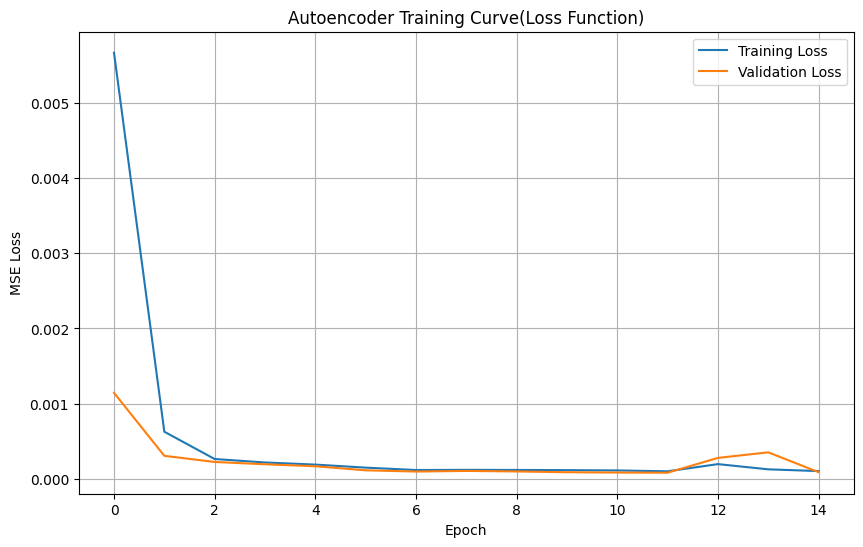

c:\Users\yashj\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\yashj\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Accuracy: 0.9004
Precision: 0.0015
Recall: 0.9056
F1 Score: 0.0029
Matthews Corrcoef: 0.0341
Correctly Predicted Samples: 1308305 / 1453017


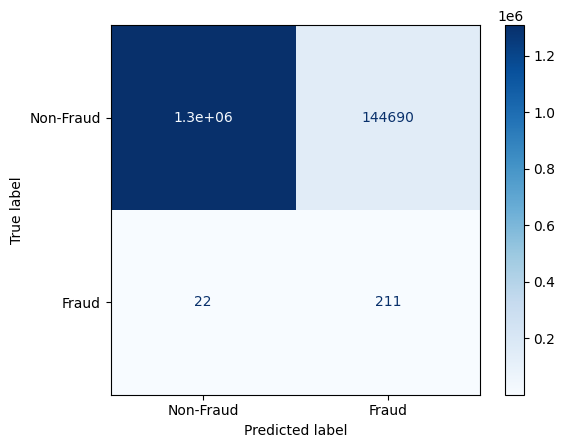

In [59]:
autoencoder_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('autoencoder', AutoencoderGMMDetector(code_dim=2, epochs=25, batch_size=64, n_components=2,learning_rate=0.0005,anomaly_percentile=10))
])


autoencoder_pipeline.fit(X_train_genuine)

autoencoder_pipeline.named_steps['autoencoder'].plot_training_loss()

X_test_full['anomaly_flag'] = autoencoder_pipeline.predict(X_test_full)
X_test_full['anomaly_score'] = autoencoder_pipeline.score_samples(X_test_full)

evaluate(y_test_full,X_test_full['anomaly_flag'])


##### Classification training

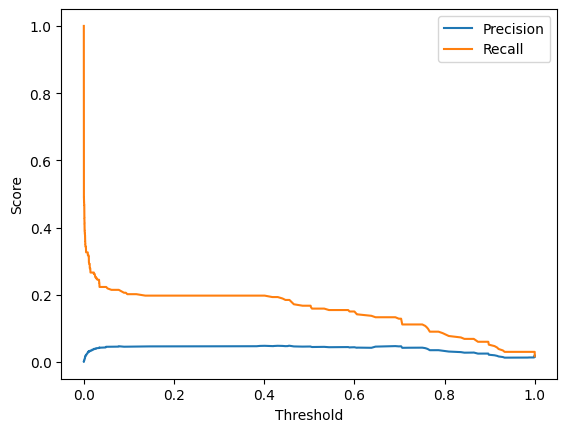

Best threshold: 0.40101323
Accuracy: 0.9992
Precision: 0.0481
Recall: 0.1974
F1 Score: 0.0773
Matthews Corrcoef: 0.0971
Correctly Predicted Samples: 1451919 / 1453017


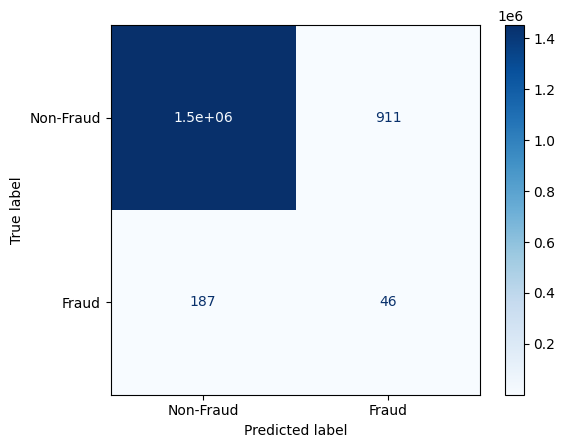

In [60]:
xgb_pipeline = Pipeline(steps=[
        ('preprocess', preprocess),
        ('model', XGB_Classifier)
])

xgb_pipeline.fit(X_train_full,y_train_full)

eval_classification(xgb_pipeline,X_test_full,y_test_full)

In [61]:
save_dir = "Models/AutoEncoders"

joblib.dump(preprocess, os.path.join(save_dir, "autoencoder_with_distance_preprocess.pkl"))

detector = autoencoder_pipeline.named_steps["autoencoder"]
detector.autoencoder.save(os.path.join(save_dir, "autoencoder_with_distance_autoencoder.keras"))

joblib.dump(detector.gmm,  os.path.join(save_dir, "autoencoder_with_distance_gmm.pkl"))

with open(os.path.join(save_dir, "autoencoder_with_distance_threshold.json"), "w") as f:
        json.dump({"threshold": float(detector.threshold)}, f)


save_dir = "Models/Classifier"
joblib.dump(xgb_pipeline, os.path.join(save_dir, "xgb_pipeline_with_distance.pkl"))

['Models/Classifier\\xgb_pipeline_with_distance.pkl']